In [1]:
using Revise
using Pkg
Pkg.develop(path="/home/stephenz/stephenz/locaTE.jl")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [2]:
using NPZ
using locaTE
using NearestNeighbors
using Graphs
using GraphSignals
using SparseArrays
using LinearAlgebra
using Plots
using StatsBase
using CUDA

In [3]:
DATA_DIR = "../../data/HSPC/"
X = npzread(string(DATA_DIR, "X.npy"));
X_pca = npzread(string(DATA_DIR, "X_pca.npy"));
X_umap = npzread(string(DATA_DIR, "X_umap.npy"));
P = npzread(string(DATA_DIR, "P_kappavelo.npy"));
dpt = npzread(string(DATA_DIR, "dpt.npy"));
R = npzread(string(DATA_DIR, "R.npy"));
C = npzread(string(DATA_DIR, "C.npy"));

In [4]:
# construct kNN and Laplacian
L = construct_normalized_laplacian(X_pca, 25);

In [5]:
TE = npzread("TE_locate_kappa.npy");
G = npzread("G_locate_kappa.npy");

In [6]:
using Random
using NNlib

In [7]:
# NMF
qnorm(x, q) = x ./ quantile(vec(x), q)
Cg = cor(X).^2; Cg[diagind(Cg)] .= 0;
# L = sparse(npzread("L_locate_kappa.npy"));

In [8]:
A = reshape(maximum(G; dims = 1), size(X, 2), size(X, 2))
G_cdf = apply_cdf_norm(G, A .+ 1e-9);
npzwrite("G_cdf.npy", G_cdf);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


In [9]:
G_static = reshape(mean(G; dims = 1), size(X, 2), size(X, 2))
G_static_cdf = cdf_norm(G_static, G_static .+ 1e-9);
npzwrite("G_static.npy", G_static)
npzwrite("G_static_cdf.npy", G_static_cdf)

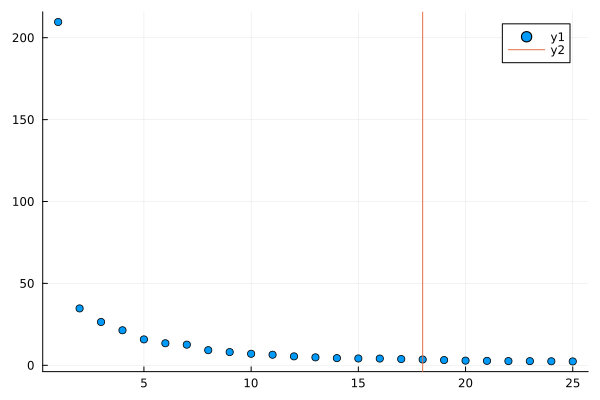

In [13]:
_, s, _ = svd(TE); s.^=2
scatter(s[1:25])
svd_rank=findall((cumsum(s) .> 0.75*sum(s)))[1]
vline!([svd_rank, ])

In [14]:
Random.seed!(0)
U, V, trace = fitnmf(cu(relu.(qnorm(TE, 0.9))),
                     [I(size(TE, 1)), I(size(TE, 2))], 1e-3*I + L,
                     cu(repeat(vec(Cg), 1, size(X, 1))'),
                     svd_rank; 
                     α = 5.0,
                     β = 0.0, 
              λ = [1, 1],
              μ = [1, 1],
              iter = 2_500, initialize = :nmf, print_iter = 50, dictionary =false, η = 1.0);
G_nmf = Array(U*V');
U = Array(U); V = Array(V);

V .*= maximum(U; dims = 1)
U ./= maximum(U; dims = 1);
# 
A = reshape(maximum(V'; dims = 1), size(X, 2), size(X, 2))
for i = 1:size(V, 2)
    x = reshape(V[:, i], size(X, 2), size(X, 2))
    V[:, i] .= vec(cdf_norm(x, A .+ 1e-9))
end
npzwrite("U.npy", U)
npzwrite("V.npy", V)

[ Info: Initializing NMF decomposition with nmf
Progress: 100%|█████████████████████████████████████████| Time: 0:02:05


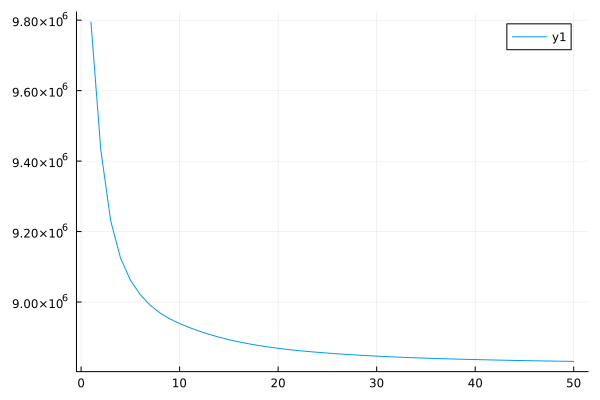

In [15]:
plot(trace)

In [173]:
# NTF
# Cg = cor(X).^2; Cg[diagind(Cg)] .= 0
# S, A, trace = fitntf(cu(reshape(qnorm(TE, 0.9), :, size(X, 2), size(X, 2))),
#                      [Array{Float32}(I(size(X, 1))), Array{Float32}(I(size(X, 2))), Array{Float32}(I(size(X, 2)))], Array{Float32}(1e-3*I + L), 
#                      cu(repeat(reshape(Cg, 1, size(X, 2), size(X, 2)), size(X, 1))), 
#                      [1, 1, 1],
#                      [1, 1, 1],
#                      10.0,
#                      0.0,
#                      36; iter = 500, dictionary = false, η = 1.0);

In [76]:
# for i = 1:length(A)
#     npzwrite("A_$i.npy", Array(A[i]))
# end

In [15]:
# plot(trace)